# Setting up a PEST interface from MODFLOW6 using the `PstFrom` class with `PyPestUtils` for advanced pilot point parameterization

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import flopy

In [2]:
import sys
sys.path.append(os.path.join("..","..","pypestutils"))

In [3]:
import pypestutils as ppu

An existing MODFLOW6 model is in the directory `freyberg_mf6`.  Lets check it out:

In [4]:
org_model_ws = os.path.join('freyberg_mf6')
os.listdir(org_model_ws)

['freyberg6.wel_stress_period_data_20.txt',
 'freyberg6.rch_recharge_2.txt',
 'freyberg6.sfr_perioddata_13.txt',
 'freyberg6.sfr_perioddata_3.txt',
 'freyberg6.rch_recharge_14.txt',
 'freyberg6_freyberg.hds',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.rch_recharge_15.txt',
 'freyberg6.sfr_perioddata_2.txt',
 'freyberg6.sfr_perioddata_12.txt',
 'freyberg6.rch_recharge_3.txt',
 'freyberg6.wel_stress_period_data_21.txt',
 'freyberg6.wel_stress_period_data_23.txt',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.sfr_perioddata_10.txt',
 'freyberg6.rch_recharge_17.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.sfr_perioddata_1.txt',
 'freyberg6.rch_recharge_16.txt',
 'freyberg6.sfr_perioddata_11.txt',
 'freyberg6.sfr_connectiondata.txt',
 'freyberg6.wel_stress_period_data_22.txt',
 'freyberg6.sto_sy_layer3.txt',
 'freyberg6.sfr_perioddata_15.txt',
 'freyberg6.rch_recharge_4.txt',
 'freyberg6.dis_top.t

You can see that all the input array and list data for this model have been written "externally" - this is key to using the `PstFrom` class. 

Let's quickly viz the model top just to remind us of what we are dealing with:

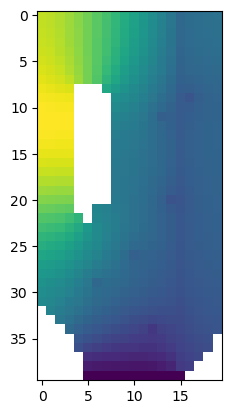

In [5]:
id_arr = np.loadtxt(os.path.join(org_model_ws,"freyberg6.dis_idomain_layer3.txt"))
top_arr = np.loadtxt(os.path.join(org_model_ws,"freyberg6.dis_top.txt"))
top_arr[id_arr==0] = np.nan
plt.imshow(top_arr)

Now let's copy those files to a temporary location just to make sure we don't goof up those original files:

In [6]:
tmp_model_ws = "temp_pst_from_ppu"
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['freyberg6.wel_stress_period_data_20.txt',
 'freyberg6.rch_recharge_2.txt',
 'freyberg6.sfr_perioddata_13.txt',
 'freyberg6.sfr_perioddata_3.txt',
 'freyberg6.rch_recharge_14.txt',
 'freyberg6_freyberg.hds',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.rch_recharge_15.txt',
 'freyberg6.sfr_perioddata_2.txt',
 'freyberg6.sfr_perioddata_12.txt',
 'freyberg6.rch_recharge_3.txt',
 'freyberg6.wel_stress_period_data_21.txt',
 'freyberg6.wel_stress_period_data_23.txt',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.sfr_perioddata_10.txt',
 'freyberg6.rch_recharge_17.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.sfr_perioddata_1.txt',
 'freyberg6.rch_recharge_16.txt',
 'freyberg6.sfr_perioddata_11.txt',
 'freyberg6.sfr_connectiondata.txt',
 'freyberg6.wel_stress_period_data_22.txt',
 'freyberg6.sto_sy_layer3.txt',
 'freyberg6.sfr_perioddata_15.txt',
 'freyberg6.rch_recharge_4.txt',
 'freyberg6.dis_top.t

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters for build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is not required to use the `PstFrom` class.

In [7]:
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_model_ws)
m = sim.get_model("freyberg6")


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading solution package freyberg6...


Here we use the simple `SpatialReference` pyemu implements to help us spatially locate parameters

In [8]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_model_ws, "freyberg6.nam"),
        delr=m.dis.delr.array, delc=m.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:10000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

Now we can instantiate a `PstFrom` class instance

In [9]:
template_ws = "freyberg6_template"
pf = pyemu.utils.PstFrom(original_d=tmp_model_ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False,start_datetime="1-1-2018")


2025-08-31 09:08:03.891857 starting: opening PstFrom.log for logging
2025-08-31 09:08:03.892093 starting PstFrom process
2025-08-31 09:08:03.892364 starting: setting up dirs
2025-08-31 09:08:03.892398 starting: removing existing new_d 'freyberg6_template'
2025-08-31 09:08:03.899069 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.006671
2025-08-31 09:08:03.899081 starting: copying original_d 'temp_pst_from_ppu' to new_d 'freyberg6_template'
2025-08-31 09:08:03.915192 finished: copying original_d 'temp_pst_from_ppu' to new_d 'freyberg6_template' took: 0:00:00.016111
2025-08-31 09:08:03.915288 finished: setting up dirs took: 0:00:00.022924


## Observations

So now that we have a `PstFrom` instance, but its just an empty container at this point, so we need to add some PEST interface "observations" and "parameters".  Let's start with observations using MODFLOW6 head.  These are stored in `heads.csv`:

In [10]:
df = pd.read_csv(os.path.join(tmp_model_ws,"heads.csv"),index_col=0)
df

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339372,34.581653,34.611271,34.872236,34.257588,34.136404,34.144487,34.027672,34.310869,34.171624,...,34.878147,34.263202,34.141617,34.150089,33.992380,34.316582,34.177245,33.909885,33.985756,33.890226
32.0,34.422185,34.680237,34.711364,34.972440,34.380690,34.245123,34.271719,34.137529,34.436670,34.312654,...,34.978308,34.385574,34.249921,34.276462,34.086955,34.441557,34.317000,33.992042,34.101898,34.004997
61.0,34.495577,34.777642,34.811214,35.082668,34.481042,34.329750,34.375621,34.218584,34.553940,34.426574,...,35.088566,34.486939,34.335503,34.381386,34.157456,34.559386,34.432021,34.057642,34.195197,34.085663
92.0,34.540966,34.847690,34.884088,35.176852,34.535381,34.371788,34.431026,34.257090,34.630529,34.489744,...,35.183003,34.542429,34.378474,34.438019,34.191072,34.636992,34.496503,34.090249,34.243224,34.120639
122.0,34.537692,34.858948,34.897412,35.213451,34.519537,34.352890,34.413872,34.236319,34.633038,34.475282,...,35.219955,34.527373,34.360122,34.421738,34.173384,34.640429,34.483080,34.076125,34.225432,34.094988
153.0,34.485665,34.805410,34.844360,35.178093,34.436538,34.277193,34.326062,34.159879,34.555096,34.382574,...,35.184970,34.444549,34.284359,34.334209,34.107416,34.563074,34.390877,34.017332,34.144442,34.014826
183.0,34.399847,34.701522,34.739064,35.076753,34.311512,34.167961,34.194918,34.051615,34.420773,34.240694,...,35.083914,34.319099,34.174579,34.202683,34.013693,34.428786,34.248822,33.931927,34.025465,33.904396
214.0,34.299522,34.569980,34.604429,34.930548,34.172792,34.050218,34.050299,33.936360,34.259318,34.081111,...,34.937729,34.179416,34.055879,34.057091,33.913596,34.266768,34.088387,33.839822,33.895627,33.789732
245.0,34.213977,34.449149,34.479660,34.781462,34.059659,33.957166,33.933007,33.846250,34.116792,33.948424,...,34.788420,34.065183,33.961867,33.938650,33.835118,34.123339,33.954564,33.767182,33.791731,33.702517


The main entry point for adding observations is (surprise) `PstFrom.add_observations()`.  This method works on the list-type observation output file.  We need to tell it what column is the index column (can be string if there is a header or int if no header) and then what columns contain quantities we want to monitor (e.g. "observe") in the control file - in this case we want to monitor all columns except the index column:

In [11]:
hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                    use_cols=list(df.columns.values),prefix="hds",)
hds_df

2025-08-31 09:08:03.929634 starting: adding observations from output file heads.csv
2025-08-31 09:08:03.929734 starting: adding observations from tabular output file '['heads.csv']'
2025-08-31 09:08:03.929858 starting: reading list-style file: freyberg6_template/heads.csv
2025-08-31 09:08:03.931579 finished: reading list-style file: freyberg6_template/heads.csv took: 0:00:00.001721
2025-08-31 09:08:03.932649 starting: building insfile for tabular output file heads.csv
2025-08-31 09:08:03.934593 finished: building insfile for tabular output file heads.csv took: 0:00:00.001944
2025-08-31 09:08:03.934622 starting: adding observation from instruction file 'freyberg6_template/heads.csv.ins'
2025-08-31 09:08:03.938839 finished: adding observation from instruction file 'freyberg6_template/heads.csv.ins' took: 0:00:00.004217
2025-08-31 09:08:03.939210 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.009476
2025-08-31 09:08:03.939241 finished: adding observat

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1,34.263202,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122,34.527373,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153,34.444549,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183,34.319099,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214,34.179416,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:640,oname:hds_otype:lst_usecol:trgw_2_9_1_time:640,34.623235,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:671,oname:hds_otype:lst_usecol:trgw_2_9_1_time:671,34.617522,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:701,oname:hds_otype:lst_usecol:trgw_2_9_1_time:701,34.682258,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:732,oname:hds_otype:lst_usecol:trgw_2_9_1_time:732,34.802225,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1


We can see that it returned a dataframe with lots of useful info: the observation names that were formed (`obsnme`), the values that were read from `heads.csv` (`obsval`) and also some generic weights and group names.  At this point, no control file has been created, we have simply prepared to add this observations to the control file later.  

In [12]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Nice!  We also have a PEST-style instruction file for those obs.

Now lets do the same for SFR observations:

In [13]:
df = pd.read_csv(os.path.join(tmp_model_ws, "sfr.csv"), index_col=0)
sfr_df = pf.add_observations("sfr.csv", insfile="sfr.csv.ins", index_cols="time", use_cols=list(df.columns.values))
sfr_df

2025-08-31 09:08:03.948043 starting: adding observations from output file sfr.csv
2025-08-31 09:08:03.948210 starting: adding observations from tabular output file '['sfr.csv']'
2025-08-31 09:08:03.948252 starting: reading list-style file: freyberg6_template/sfr.csv
2025-08-31 09:08:03.948842 finished: reading list-style file: freyberg6_template/sfr.csv took: 0:00:00.000590
2025-08-31 09:08:03.949147 starting: building insfile for tabular output file sfr.csv
2025-08-31 09:08:03.950883 finished: building insfile for tabular output file sfr.csv took: 0:00:00.001736
2025-08-31 09:08:03.950922 starting: adding observation from instruction file 'freyberg6_template/sfr.csv.ins'
2025-08-31 09:08:03.952672 finished: adding observation from instruction file 'freyberg6_template/sfr.csv.ins' took: 0:00:00.001750
2025-08-31 09:08:03.952963 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.004753
2025-08-31 09:08:03.952996 finished: adding observations from output f

,obsnme,obsval,weight,obgnme
oname:sfr.csv_otype:lst_usecol:gage_1_time:1,oname:sfr.csv_otype:lst_usecol:gage_1_time:1,1206.10,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:122,oname:sfr.csv_otype:lst_usecol:gage_1_time:122,1981.70,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:153,oname:sfr.csv_otype:lst_usecol:gage_1_time:153,1692.10,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:183,oname:sfr.csv_otype:lst_usecol:gage_1_time:183,1290.50,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:214,oname:sfr.csv_otype:lst_usecol:gage_1_time:214,871.34,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
...,...,...,...,...
oname:sfr.csv_otype:lst_usecol:tailwater_time:640,oname:sfr.csv_otype:lst_usecol:tailwater_time:640,-162.42,1.0,oname:sfr.csv_otype:lst_usecol:tailwater
oname:sfr.csv_otype:lst_usecol:tailwater_time:671,oname:sfr.csv_otype:lst_usecol:tailwater_time:671,-214.05,1.0,oname:sfr.csv_otype:lst_usecol:tailwater
oname:sfr.csv_otype:lst_usecol:tailwater_time:701,oname:sfr.csv_otype:lst_usecol:tailwater_time:701,-343.65,1.0,oname:sfr.csv_otype:lst_usecol:tailwater
oname:sfr.csv_otype:lst_usecol:tailwater_time:732,oname:sfr.csv_otype:lst_usecol:tailwater_time:732,-517.00,1.0,oname:sfr.csv_otype:lst_usecol:tailwater


Sweet as!  Now that we have some observations, let's add parameters!

## Pilot points and `PyPestUtils`

This notebook is mostly meant to demonstrate some advanced pilot point parameterization that is possible with `PyPestUtils`, so we will only focus on HK and VK pilot point parameters.  This is just to keep the example short.  In practice, please please please parameterize boundary conditions too!

In [14]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=5000,bearing=0,anisotropy=1)
pp_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

spatial variogram


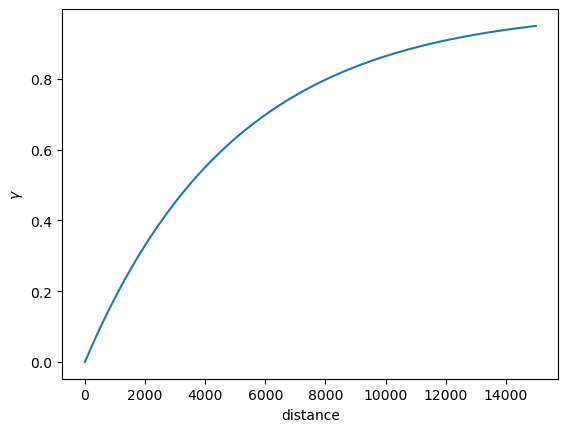

In [15]:
pp_gs.plot()
print("spatial variogram")

Now let's get the idomain array to use as a zone array - this keeps us from setting up parameters in inactive model cells:

In [16]:
ib = m.dis.idomain[0].array

Find HK files for the upper and lower model layers (assuming model layer 2 is a semi-confining unit)

In [17]:
hk_arr_files = [f for f in os.listdir(tmp_model_ws) if "npf_k_" in f and f.endswith(".txt") and "layer2" not in f]
hk_arr_files

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer3.txt']

In [18]:
arr_file = "freyberg6.npf_k_layer1.txt"
tag = arr_file.split('.')[1].replace("_","-")
pf.add_parameters(filenames=arr_file,par_type="pilotpoints",
                   par_name_base=tag,pargp=tag,zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                   pp_options={"pp_space":3},geostruct=pp_gs)
#let's also add the resulting hk array that modflow sees as observations
# so we can make easy plots later...
pf.add_observations(arr_file,prefix=tag,
                    obsgp=tag,zone_array=ib)

2025-08-31 09:08:04.054642 transform was not passed, setting default transform to 'log'
2025-08-31 09:08:04.054968 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2025-08-31 09:08:04.055041 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:1.0,bearing:0.0

2025-08-31 09:08:04.055077 starting: loading array freyberg6_template/freyberg6.npf_k_layer1.txt
2025-08-31 09:08:04.055249 WARNING: 
_load_array_get_fmt(), likely fixed format file:
freyberg6.npf_k_layer1.txt appears to contain some float notation (%F) values.
Can't define a generic format specifier that
will guarantee file is readable by downstream engine.
Will try to use %E, but this could cause issues
downstream...
2025-08-31 09:08:04.055281 finished: loading array freyberg6_template/freyberg6.npf_k_layer1.txt took: 0:00:00.000204
2025-08-31 09:08:04.055346 loaded array 'temp_pst_from_ppu/freyberg6.npf_k_layer1.txt' of shape

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.055249 WARNING: 
_load_array_get_fmt(), likely fixed format file:
freyberg6.npf_k_layer1.txt appears to contain some float notation (%F) values.
Can't define a generic format specifier that
will guarantee file is readable by downstream engine.
Will try to use %E, but this could cause issues
downstream...



,obsnme,obsval,weight,obgnme
oname:npf-k-layer1_otype:arr_i:0_j:0_zone:1,oname:npf-k-layer1_otype:arr_i:0_j:0_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:0_j:10_zone:1,oname:npf-k-layer1_otype:arr_i:0_j:10_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:0_j:11_zone:1,oname:npf-k-layer1_otype:arr_i:0_j:11_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:0_j:12_zone:1,oname:npf-k-layer1_otype:arr_i:0_j:12_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:0_j:13_zone:1,oname:npf-k-layer1_otype:arr_i:0_j:13_zone:1,3.0,1.0,npf-k-layer1
...,...,...,...,...
oname:npf-k-layer1_otype:arr_i:9_j:1_zone:1,oname:npf-k-layer1_otype:arr_i:9_j:1_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:9_j:2_zone:1,oname:npf-k-layer1_otype:arr_i:9_j:2_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:9_j:3_zone:1,oname:npf-k-layer1_otype:arr_i:9_j:3_zone:1,3.0,1.0,npf-k-layer1
oname:npf-k-layer1_otype:arr_i:9_j:8_zone:1,oname:npf-k-layer1_otype:arr_i:9_j:8_zone:1,3.0,1.0,npf-k-layer1


If you are familiar with how `PstFrom` has worked historically, we handed off the process to solve for the factor file (which requires solving the kriging equations for each active node) to a pure python (well, with pandas and numpy).  This was ok for toy models, but hella slow for big ugly models.  If you look at the log entries above, you should see that the instead, `PstFrom` successfully handed off the solve to `PyPestUtils`, which is exponentially faster for big models.  sweet ez! 

In [19]:
tpl_files = [f for f in os.listdir(template_ws) if f.endswith(".tpl")]
tpl_files

['npf-k-layer1_inst0pp.dat.tpl']

In [20]:
with open(os.path.join(template_ws,tpl_files[0]),'r') as f:
    for _ in range(2):
        print(f.readline().strip())
        

ptf ~
pp_0000 375.0 9625.0 1 ~    pname:npf-k-layer1_inst:0_ptype:pp_pstyle:m_i:1_j:1_zone:1    ~



So those might look like pretty redic parameter names, but they contain heaps of metadata to help you post process things later...

So those are you standard pilot points for HK in layer 1 - same as it ever was...

## Geostatistical hyper-parameters

For the HK layer 1 pilot points, we used a standard geostatistical structure - the ever popular exponential variogram.  But what if the properties that define that variogram were themselves uncertain?  Like what is the anisotropy ellipse varied in space across the model domain?  What does this imply?  Well, technically speaking, those variogram properties can be conceptualized as "hyper parameters" in that they influence the underlying parameters (in this case, the pilot points) in hierarchical sense.  That is, the bearing of the anisotropy of the variogram changes, then the resulting interpolation from the pilot points to grid changes.  But where it gets really deep is that we need to define correlation structures for these spatially varying hyper pars, so they themselves have plausible spatial patterns...Seen that movie inception?!

In `PyPestUtils`, we can supply the pilot-point-to-grid interpolation process with arrays of hyper-parameter values, one array for each variogram property.  The result of this hyper parameter mess is referred to as a non-stationary spatial parameterization.  buckle up...

First let's define some additional geostatistical structures:

In [21]:
value_v = pyemu.geostats.ExpVario(contribution=1, a=5000, anisotropy=2, bearing=0.0)
value_gs = pyemu.geostats.GeoStruct(variograms=value_v)
bearing_v = pyemu.geostats.ExpVario(contribution=1,a=5000,anisotropy=2,bearing=90.0)
bearing_gs = pyemu.geostats.GeoStruct(variograms=bearing_v)

In [22]:
arr_file = "freyberg6.npf_k_layer3.txt"
tag = arr_file.split('.')[1].replace("_","-")
pf.add_parameters(filenames=arr_file,par_type="pilotpoints",
                   par_name_base=tag,pargp=tag,zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                 pp_options={"pp_space":3,"prep_hyperpars":True},geostruct=value_gs,
                 apply_order=2)
pf.add_observations(arr_file,prefix=tag,
                    obsgp=tag,zone_array=ib)

2025-08-31 09:08:04.110126 transform was not passed, setting default transform to 'log'
2025-08-31 09:08:04.110341 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2025-08-31 09:08:04.110431 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:2.0,bearing:0.0

2025-08-31 09:08:04.110453 WARNING: 0) Inconsistency between geostruct transform and partrans.
2025-08-31 09:08:04.110480 WARNING: 1) Setting geostruct transform to log
2025-08-31 09:08:04.110491 WARNING: -) Better to pass an appropriately transformed geostruct
2025-08-31 09:08:04.110527 starting: loading array freyberg6_template/freyberg6.npf_k_layer3.txt
2025-08-31 09:08:04.111007 WARNING: 
_load_array_get_fmt(), likely fixed format file:
freyberg6.npf_k_layer3.txt appears to contain some float notation (%F) values.
Can't define a generic format specifier that
will guarantee file is readable by downstream engine.
Will try to u

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.110453 WARNING: 0) Inconsistency between geostruct transform and partrans.

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.110480 WARNING: 1) Setting geostruct transform to log

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.110491 WARNING: -) Better to pass an appropriately transformed geostruct

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.111007 WARNING: 
_load_array_get_fmt(), likely fixed format file:
freyberg6.npf_k_layer3.txt appears to contain some float notation (%F) values.
Can't define a generic format specifier that
will guarantee file is readable by downstream engine.
Will try to use %E, but this could cause issues
downstream...



,obsnme,obsval,weight,obgnme
oname:npf-k-layer3_otype:arr_i:0_j:0_zone:1,oname:npf-k-layer3_otype:arr_i:0_j:0_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:0_j:10_zone:1,oname:npf-k-layer3_otype:arr_i:0_j:10_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:0_j:11_zone:1,oname:npf-k-layer3_otype:arr_i:0_j:11_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:0_j:12_zone:1,oname:npf-k-layer3_otype:arr_i:0_j:12_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:0_j:13_zone:1,oname:npf-k-layer3_otype:arr_i:0_j:13_zone:1,30.0,1.0,npf-k-layer3
...,...,...,...,...
oname:npf-k-layer3_otype:arr_i:9_j:1_zone:1,oname:npf-k-layer3_otype:arr_i:9_j:1_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:9_j:2_zone:1,oname:npf-k-layer3_otype:arr_i:9_j:2_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:9_j:3_zone:1,oname:npf-k-layer3_otype:arr_i:9_j:3_zone:1,30.0,1.0,npf-k-layer3
oname:npf-k-layer3_otype:arr_i:9_j:8_zone:1,oname:npf-k-layer3_otype:arr_i:9_j:8_zone:1,30.0,1.0,npf-k-layer3


In [23]:
hyperpar_files = [f for f in os.listdir(pf.new_d) if tag in f]
hyperpar_files

['npf-k-layer3.bearing.dat',
 'npf-k-layer3.corrlen.dat',
 'npf-k-layer3.aniso.dat',
 'npf-k-layer3.config.csv',
 'npf-k-layer3_inst0pp.dat.shp',
 'npf-k-layer3_inst0pp.dat',
 'npf-k-layer3_inst0pp.dat.shx',
 'npf-k-layer3_inst0pp.dat.tpl',
 'npf-k-layer3.zone.dat',
 'npf-k-layer3_inst0pp.dat.dbf',
 'npf-k-layer3.gridinfo.dat',
 'npf-k-layer3_inst0pp.dat.zone']

when we supplied the "prep_hyperpars" as `True` above, that triggered `PstFrom` to do something different.  Instead of solving for the pilot point kriging factors as before, now, we have array-based files for the geostatistical hyper parameters, as well as some additional quantities we need to "apply" these hyper parameter at runtime.  This is a key difference:  When the pilot point variogram is changing for each model run, we need to re-solve for the kriging factors for each model run...

We snuck in something else too - see that `apply_order` argument?  That is how we can control what order of files being processed by the run-time multiplier parameter function.  Since we are going to parameterize the hyper parameters and there is an implicit order between these hyper parameters and the underlying pilot points, we need to make sure the hyper parameters are processed first.  

Lets setup some hyper parameters for estimation.  We will use a constant for the anisotropy ratio, but use pilot points for the bearing:

In [24]:
afile = 'npf-k-layer3.aniso.dat'
tag = afile.split('.')[0].replace("_","-")+"-aniso"
pf.add_parameters(afile,par_type="constant",par_name_base=tag,
                  pargp=tag,lower_bound=-1.0,upper_bound=1.0,
                  apply_order=1,
                  par_style="a",transform="none",initial_value=0.0)
pf.add_observations(afile, prefix=tag, obsgp=tag)
bfile = 'npf-k-layer3.bearing.dat'
tag = bfile.split('.')[0].replace("_","-")+"-bearing"
pf.add_parameters(bfile, par_type="pilotpoints", par_name_base=tag,
                  pargp=tag, pp_space=6,lower_bound=-45,upper_bound=45,
                  par_style="a",transform="none",
                  pp_options={"try_use_ppu":True},
                  apply_order=1,geostruct=bearing_gs)
pf.add_observations(bfile, prefix=tag, obsgp=tag)                

2025-08-31 09:08:04.162311 starting: adding constant type a style parameters for file(s) ['npf-k-layer3.aniso.dat']
2025-08-31 09:08:04.162491 starting: loading array freyberg6_template/npf-k-layer3.aniso.dat
2025-08-31 09:08:04.163013 finished: loading array freyberg6_template/npf-k-layer3.aniso.dat took: 0:00:00.000522
2025-08-31 09:08:04.163086 loaded array 'temp_pst_from_ppu/npf-k-layer3.aniso.dat' of shape (40, 20)
2025-08-31 09:08:04.163506 starting: writing array-style template file 'freyberg6_template/npf-k-layer3-aniso_inst0_constant.csv.tpl'
2025-08-31 09:08:04.163525 starting: writing template file freyberg6_template/npf-k-layer3-aniso_inst0_constant.csv.tpl for ['npf-k-layer3-aniso_inst:0']
2025-08-31 09:08:04.166238 finished: writing template file freyberg6_template/npf-k-layer3-aniso_inst0_constant.csv.tpl for ['npf-k-layer3-aniso_inst:0'] took: 0:00:00.002713
2025-08-31 09:08:04.166339 starting: writing array-based template file 'freyberg6_template/npf-k-layer3-aniso_ins

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.175252 WARNING: Directly passing 'pp_space' has been deprecated and will eventually be removed, please use pp_options['pp_space'] instead.



,obsnme,obsval,weight,obgnme
oname:npf-k-layer3-bearing_otype:arr_i:0_j:0,oname:npf-k-layer3-bearing_otype:arr_i:0_j:0,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:0_j:1,oname:npf-k-layer3-bearing_otype:arr_i:0_j:1,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:0_j:10,oname:npf-k-layer3-bearing_otype:arr_i:0_j:10,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:0_j:11,oname:npf-k-layer3-bearing_otype:arr_i:0_j:11,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:0_j:12,oname:npf-k-layer3-bearing_otype:arr_i:0_j:12,0.0,1.0,npf-k-layer3-bearing
...,...,...,...,...
oname:npf-k-layer3-bearing_otype:arr_i:9_j:5,oname:npf-k-layer3-bearing_otype:arr_i:9_j:5,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:9_j:6,oname:npf-k-layer3-bearing_otype:arr_i:9_j:6,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:9_j:7,oname:npf-k-layer3-bearing_otype:arr_i:9_j:7,0.0,1.0,npf-k-layer3-bearing
oname:npf-k-layer3-bearing_otype:arr_i:9_j:8,oname:npf-k-layer3-bearing_otype:arr_i:9_j:8,0.0,1.0,npf-k-layer3-bearing


Notice that the `apply_order` for these hyper pars is 1 so that any processing for these quantities happens before the actual underlying pilot points are processed

## "These go to 11" - amp'ing things up with categorization

Sometimes, the world we want to simulate might be better represented as categorical instead continuous.  That is, rather than smoothly varying property fields, we want fields that are either a high value or a low value (please dont ask for more than 2 categories!).  In this case, depending on how you plan to assimilate data (that is, what inversion algorithm you are planning to you), we can accommodate this preference for categorical fields.  

This is pretty advanced and also dense.  There is another example notebook the describes the categorization process in detail.  Here we will just blast thru it....

lets setup non-stationary categorical parameterization for the VK of layer 2 (the semi confining unit).  We can conceptualize this as a semi-confining unit that has "windows" in it that connects the two aquifers.  Where there is not a window, the Vk will be very low, where there is a window, the VK will be much higher. Let's also assume the windows in the confining unit where created when a stream eroded thru it, so the shape of these windows will be higher-order (not derived from a standard geostatistical 2-point process), but rather from connected features.

In what follows, we setup this complex parameterization.  We also add lots of aux observations to lets plot and viz the steps in this parameterization process.

In [25]:
arr_file = "freyberg6.npf_k33_layer2.txt"
print(arr_file)
k = int(arr_file.split(".")[1][-1]) - 1
pth_arr_file = os.path.join(pf.new_d,arr_file)
arr = np.loadtxt(pth_arr_file)
cat_dict = {1:[0.4,arr.mean()],2:[0.6,arr.mean()]}

#this is where we initialize the categorization process - it will operate on the 
# layer 2 VK array just before MODFLOW runs
thresharr,threshcsv = pyemu.helpers.setup_threshold_pars(pth_arr_file,cat_dict=cat_dict,
                                                         testing_workspace=pf.new_d,inact_arr=ib)

# the corresponding apply function
pf.pre_py_cmds.append("pyemu.helpers.apply_threshold_pars('{0}')".format(os.path.split(threshcsv)[1]))
prefix = arr_file.split('.')[1].replace("_","-")

pth_arr_file = os.path.join(pf.new_d,arr_file)
arr = np.loadtxt(pth_arr_file)

tag = arr_file.split('.')[1].replace("_","-") + "_pp"
prefix = arr_file.split('.')[1].replace("_","-")
#setup pilot points with hyper pars for the thresholding array (the array that will drive the 
# categorization process).  Notice the apply_order arg being used 
pf.add_parameters(filenames=os.path.split(thresharr)[1],par_type="pilotpoints",transform="none",
                  par_name_base=tag+"-threshpp_k:{0}".format(k),
                  pargp=tag + "-threshpp_k:{0}".format(k),
                  lower_bound=0.0,upper_bound=2.0,par_style="m",
                  pp_options={"try_use_ppu":False,"prep_hyperpars":True,"pp_space":5},
                  apply_order=2,geostruct=value_gs
                  )

tag = arr_file.split('.')[1].replace("_","-")
# a constant parameter for the anisotropy of the thresholding array
# Notice the apply_order arg being used
tfiles = [f for f in os.listdir(pf.new_d) if tag in f]
afile = [f for f in tfiles if "aniso" in f][0]
pf.add_parameters(afile,par_type="constant",par_name_base=tag+"-aniso",
                  pargp=tag+"-aniso",lower_bound=-1.0,upper_bound=1.0,
                  apply_order=1,
                  par_style="a",transform="none",initial_value=0.0)
# obs for the anisotropy field
pf.add_observations(afile, prefix=tag+"-aniso", obsgp=tag+"-aniso")

# pilot points for the bearing array of the geostructure of the thresholding array
# Notice the apply_order arg being used
bfile = [f for f in tfiles if "bearing" in f][0]
pf.add_parameters(bfile, par_type="pilotpoints", par_name_base=tag + "-bearing",
                  pargp=tag + "-bearing", pp_space=6,lower_bound=-45,upper_bound=45,
                  par_style="a",transform="none",
                  pp_options={"try_use_ppu":True},
                  apply_order=1,geostruct=bearing_gs)
# obs for the bearing array
pf.add_observations(bfile, prefix=tag + "-bearing", obsgp=tag + "-bearing")                

# list style parameters for the quantities used in the categorization process
# We will manipulate these initial values and bounds later
pf.add_parameters(filenames=os.path.split(threshcsv)[1], par_type="grid",index_cols=["threshcat"],
                  use_cols=["threshproportion","threshfill"],
                  par_name_base=[prefix+"threshproportion_k:{0}".format(k),prefix+"threshfill_k:{0}".format(k)],
                  pargp=[prefix+"threshproportion_k:{0}".format(k),prefix+"threshfill_k:{0}".format(k)],
                  lower_bound=[0.1,0.1],upper_bound=[10.0,10.0],transform="none",par_style='d')

# obs of the resulting Vk array that MODFLOW uses
pf.add_observations(arr_file,prefix=tag,
                    obsgp=tag,zone_array=ib)

# observations of the categorized array
pf.add_observations(arr_file+".threshcat.dat", prefix="tcatarr-" + prefix+"_k:{0}".format(k),
                    obsgp="tcatarr-" + prefix+"_k:{0}".format(k),zone_array=ib)

# observations of the thresholding array
pf.add_observations(arr_file + ".thresharr.dat",
                    prefix=tag+'-thresharr',
                    obsgp=tag+'-thresharr', zone_array=ib)

# observations of the results of the thresholding process
df = pd.read_csv(threshcsv.replace(".csv","_results.csv"),index_col=0)
pf.add_observations(os.path.split(threshcsv)[1].replace(".csv","_results.csv"),index_cols="threshcat",use_cols=df.columns.tolist(),prefix=prefix+"-results_k:{0}".format(k),
                    obsgp=prefix+"-results_k:{0}".format(k),ofile_sep=",")


freyberg6.npf_k33_layer2.txt
         using a homogeneous array with first category fill value 0.03
2025-08-31 09:08:04.215202 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt.thresharr.dat']
2025-08-31 09:08:04.215230 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:2.0,bearing:0.0
 took: 0:00:00.104799
2025-08-31 09:08:04.215241 WARNING: 0) Inconsistency between geostruct transform and partrans.
2025-08-31 09:08:04.215282 WARNING: 1) Setting geostruct transform to none
2025-08-31 09:08:04.215294 WARNING: 2) This will create a new copy of geostruct
2025-08-31 09:08:04.215309 WARNING: -) Better to pass an appropriately transformed geostruct
2025-08-31 09:08:04.215337 starting: loading array freyberg6_template/freyberg6.npf_k33_layer2.txt.thresharr.dat
2025-08-31 09:08:04.215529 finished: loading array freyberg6_template/freyberg6.npf_k33_layer2.txt.thresharr.dat took: 0:00:00.0001

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.215241 WARNING: 0) Inconsistency between geostruct transform and partrans.

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.215282 WARNING: 1) Setting geostruct transform to none

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.215294 WARNING: 2) This will create a new copy of geostruct

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.215309 WARNING: -) Better to pass an appropriately transformed geostruct

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.215946 WARNING: `prep_hyperpars` requested but `try_use_ppu` set to False.
Setting `try_use_ppu` to True and testing import



2025-08-31 09:08:04.257697 finished: adding observation from instruction file 'freyberg6_template/npf-k33-layer2_pp-threshpp_k-1.aniso.dat.ins' took: 0:00:00.005023
2025-08-31 09:08:04.257873 finished: adding observations from array output file 'npf-k33-layer2_pp-threshpp_k-1.aniso.dat' took: 0:00:00.005782
2025-08-31 09:08:04.257966 finished: adding observations from output file npf-k33-layer2_pp-threshpp_k-1.aniso.dat took: 0:00:00.005889
2025-08-31 09:08:04.258105 starting: adding pilotpoints type a style parameters for file(s) ['npf-k33-layer2_pp-threshpp_k-1.bearing.dat']
2025-08-31 09:08:04.258128 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:2.0,bearing:90.0
 took: 0:00:00.083546
2025-08-31 09:08:04.258154 starting: loading array freyberg6_template/npf-k33-layer2_pp-threshpp_k-1.bearing.dat
2025-08-31 09:08:04.258301 finished: loading array freyberg6_template/npf-k33-layer2_pp-threshpp_k-1.bearing.dat took: 0:00:00.0

/Users/jwhite/Dev/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-08-31 09:08:04.258691 WARNING: Directly passing 'pp_space' has been deprecated and will eventually be removed, please use pp_options['pp_space'] instead.



,obsnme,obsval,weight,obgnme
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:proportion_threshcat:1,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:proportion_threshcat:1,1.00,1.0,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:proportion
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:proportion_threshcat:2,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:proportion_threshcat:2,0.00,1.0,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:proportion
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshfill_threshcat:1,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshfill_threshcat:1,0.03,1.0,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshfill
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshfill_threshcat:2,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshfill_threshcat:2,0.03,1.0,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshfill
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshold_threshcat:1,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshold_threshcat:1,0.00,1.0,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshold
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshold_threshcat:2,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshold_threshcat:2,0.00,1.0,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshold
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshproportion_threshcat:1,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshproportion_threshcat:1,0.40,1.0,npf-k33-layer2-results_k:1
oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshproportion_threshcat:2,oname:npf-k33-layer2-results_k:1_otype:lst_usecol:threshproportion_threshcat:2,0.60,1.0,npf-k33-layer2-results_k:1


### build the control file, pest interface files, and forward run script
At this point, we have some parameters and some observations, so we can create a control file:

In [26]:
pf.mod_sys_cmds.append("mf6")
pf.pre_py_cmds.insert(0,"import sys")
pf.pre_py_cmds.insert(1,"sys.path.append(os.path.join('..','..','..','pypestutils'))")
pst = pf.build_pst()

noptmax:0, npar_adj:232, nnz_obs:7463
2025-08-31 09:08:04.375236 forward_run line:pyemu.os_utils.run(r'mf6')



In [27]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    try:
       os.remove(r'freyberg6.npf_k_layer1.txt')
    except Exception as e:
       print(r'error removing tmp file:freyberg6.npf_k_layer1.txt')
    try:
       os.remove(r'freyberg6.npf_k_layer3.txt')
    except Exception as e:
       print(r'error removing tmp file:freyberg6.npf_k_layer3.txt')
    try:
       os.remove(r'npf-k-layer3.aniso.dat')
    except Exception as e:
       print(r'error removing tmp file:npf-k-layer3.aniso.dat')
    try:
       os.remove(r'npf-k-layer3.bearing.dat')
    except Exception as e:
       print(r'error removing tmp file:npf-k-layer3.bearing.dat')
    try:
       os.remove(r'npf-k33-layer2_pp-threshpp_k-1.aniso.dat

## Setting initial parameter bounds and values

Here is some gory detail regarding defining the hyper parameters for both layer 3 HK and layer 2 VK...

In [28]:
#set the initial and bounds for the fill values
par = pst.parameter_data

apar = par.loc[par.pname.str.contains("aniso"),:]
bpar = par.loc[par.pname.str.contains("bearing"), :]
par.loc[apar.parnme.str.contains("layer3").index,"parval1"] = 3
par.loc[apar.parnme.str.contains("layer3").index,"parlbnd"] = 1
par.loc[apar.parnme.str.contains("layer3").index,"parubnd"] = 5

par.loc[apar.parnme.str.contains("layer2").index,"parval1"] = 2
par.loc[apar.parnme.str.contains("layer2").index,"parlbnd"] = 0
par.loc[apar.parnme.str.contains("layer2").index,"parubnd"] = 4

par.loc[bpar.parnme.str.contains("layer3").index,"parval1"] = 0
par.loc[bpar.parnme.str.contains("layer3").index,"parlbnd"] = -90
par.loc[bpar.parnme.str.contains("layer3").index,"parubnd"] = 90

par.loc[bpar.parnme.str.contains("layer2").index,"parval1"] = 0
par.loc[bpar.parnme.str.contains("layer2").index,"parlbnd"] = -90
par.loc[bpar.parnme.str.contains("layer2").index,"parubnd"] = 90

cat1par = par.loc[par.apply(lambda x: x.threshcat=="0" and x.usecol=="threshfill",axis=1),"parnme"]
cat2par = par.loc[par.apply(lambda x: x.threshcat == "1" and x.usecol == "threshfill", axis=1), "parnme"]
assert cat1par.shape[0] == 1
assert cat2par.shape[0] == 1

cat1parvk = [p for p in cat1par if "k:1" in p]
cat2parvk = [p for p in cat2par if "k:1" in p]
for lst in [cat2parvk,cat1parvk]:
    assert len(lst) > 0

#these are the values that will fill the two categories of VK - 
# one is low (clay) and one is high (sand - the windows)
par.loc[cat1parvk, "parval1"] = 0.0001
par.loc[cat1parvk, "parubnd"] = 0.01
par.loc[cat1parvk, "parlbnd"] = 0.000001
par.loc[cat1parvk, "partrans"] = "log"
par.loc[cat2parvk, "parval1"] = 0.1
par.loc[cat2parvk, "parubnd"] = 1
par.loc[cat2parvk, "parlbnd"] = 0.01
par.loc[cat2parvk, "partrans"] = "log"


cat1par = par.loc[par.apply(lambda x: x.threshcat == "0" and x.usecol == "threshproportion", axis=1), "parnme"]
cat2par = par.loc[par.apply(lambda x: x.threshcat == "1" and x.usecol == "threshproportion", axis=1), "parnme"]

assert cat1par.shape[0] == 1
assert cat2par.shape[0] == 1

#these are the proportions of clay and sand in the resulting categorical array
#really under the hood, only the first one is used, so we can fix the other.
par.loc[cat1par, "parval1"] = 0.95
par.loc[cat1par, "parubnd"] = 1.0
par.loc[cat1par, "parlbnd"] = 0.9
par.loc[cat1par,"partrans"] = "none"

# since the apply method only looks that first proportion, we can just fix this one
par.loc[cat2par, "parval1"] = 1
par.loc[cat2par, "parubnd"] = 1
par.loc[cat2par, "parlbnd"] = 1
par.loc[cat2par,"partrans"] = "fixed"


# Generating a prior parameter ensemble, then run and viz a real

In [29]:
np.random.seed(122341)
pe = pf.draw(num_reals=100)

2025-08-31 09:08:04.408167 starting: drawing realizations
2025-08-31 09:08:04.408845 starting: Drawing 232 non-specsim pars
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf-k-layer1']
build cov matrix
done
getting diag var cov 79
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:2.0,bearing:0.0

working on pargroups ['npf-k-layer3']
build cov matrix
done
getting diag var cov 79
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:5000.0,anisotropy:2.0,bearing:90.0

working on pargroups ['npf-k-layer3-bearing']
build cov matrix
done
getting diag var cov 18
scaling full cov by diag var cov
working on pargroups ['npf-k33-layer2-bearing']
build cov matrix
done
getting diag var cov 18
scaling full cov by diag var cov
processing  name:struct1,nugget

In [30]:
pe.to_csv(os.path.join(template_ws,"prior.csv"))

In [31]:
real = 0
pst_name = "real_{0}.pst".format(real)
pst.parameter_data.loc[pst.adj_par_names,"parval1"] = pe.loc[real,pst.adj_par_names].values

In [32]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pf.new_d,pst_name))

noptmax:0, npar_adj:231, nnz_obs:7463


In [33]:
pyemu.os_utils.run("pestpp-ies {0}".format(pst_name),cwd=pf.new_d)

pestpp-ies real_0.pst


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/31/25 09:08:04
...processing command line: ' pestpp-ies real_0.pst'
...using serial run manager

using control file: "real_0.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/freyberg6_template"
on host: "jwhites-MacBook-Pro.local"

processing control file real_0.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1
parameter warning: 1 parameters are at lower bound
parameter warning: 1 parameters are at upper bound
1 parameter warnings, see rec file 
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  

  ---  'noptmax'=0, running control file parameter values and quitting  ---  
...saving control file

In [34]:
pst.set_res(os.path.join(pf.new_d,pst_name.replace(".pst",".base.rei")))
res = pst.res
obs = pst.observation_data
grps = [o for o in obs.obgnme.unique() if o.startswith("npf") and "result" not in o and "aniso" not in o]
grps

['npf-k-layer1',
 'npf-k-layer3',
 'npf-k-layer3-bearing',
 'npf-k33-layer2-bearing',
 'npf-k33-layer2',
 'npf-k33-layer2-thresharr']

In [35]:
gobs = obs.loc[obs.obgnme.isin(grps),:].copy()
gobs["i"] = gobs.i.astype(int)
gobs["j"] = gobs.j.astype(int)
gobs["k"] = gobs.obgnme.apply(lambda x: int(x.split('-')[2].replace("layer","")) - 1)

In [36]:
uk = gobs.k.unique()
uk.sort()

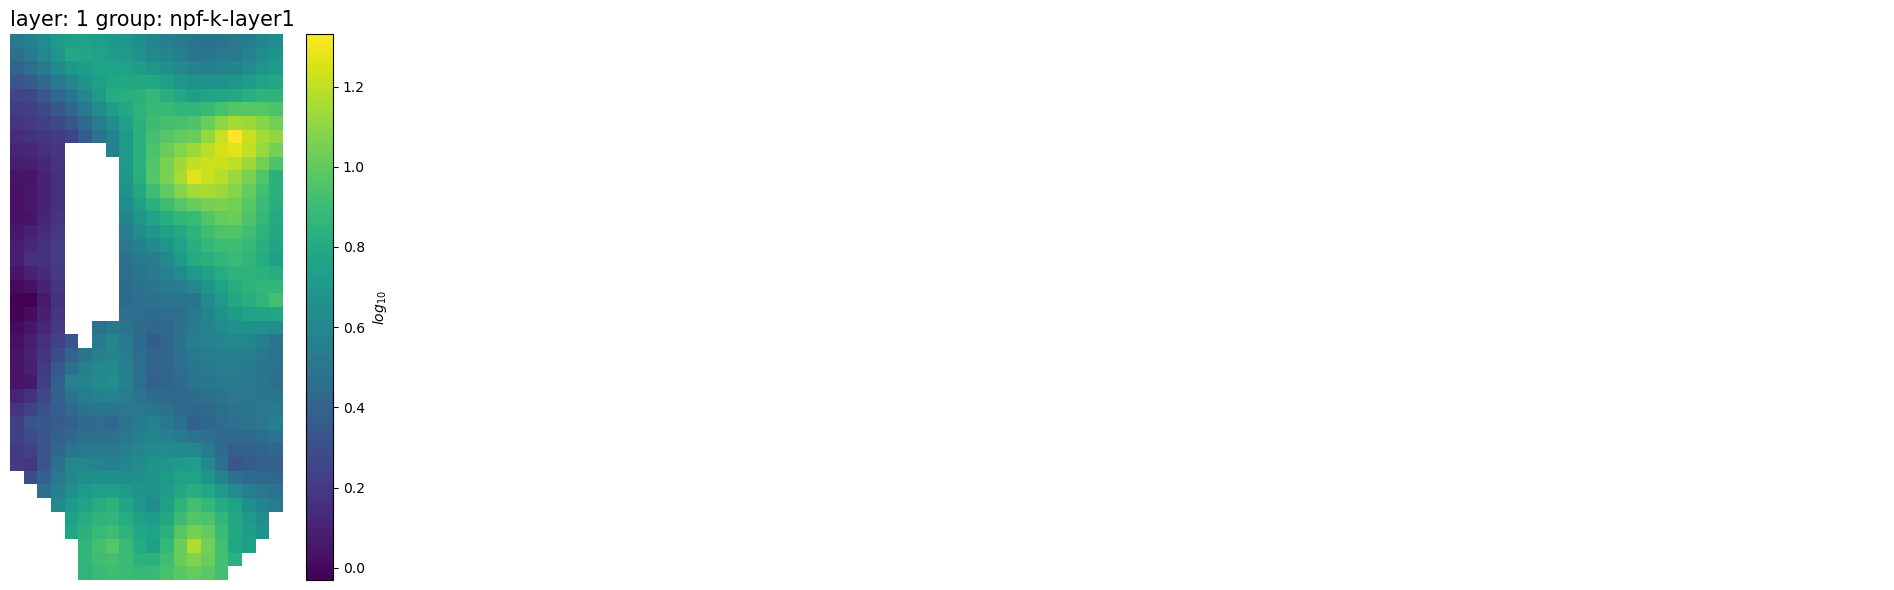

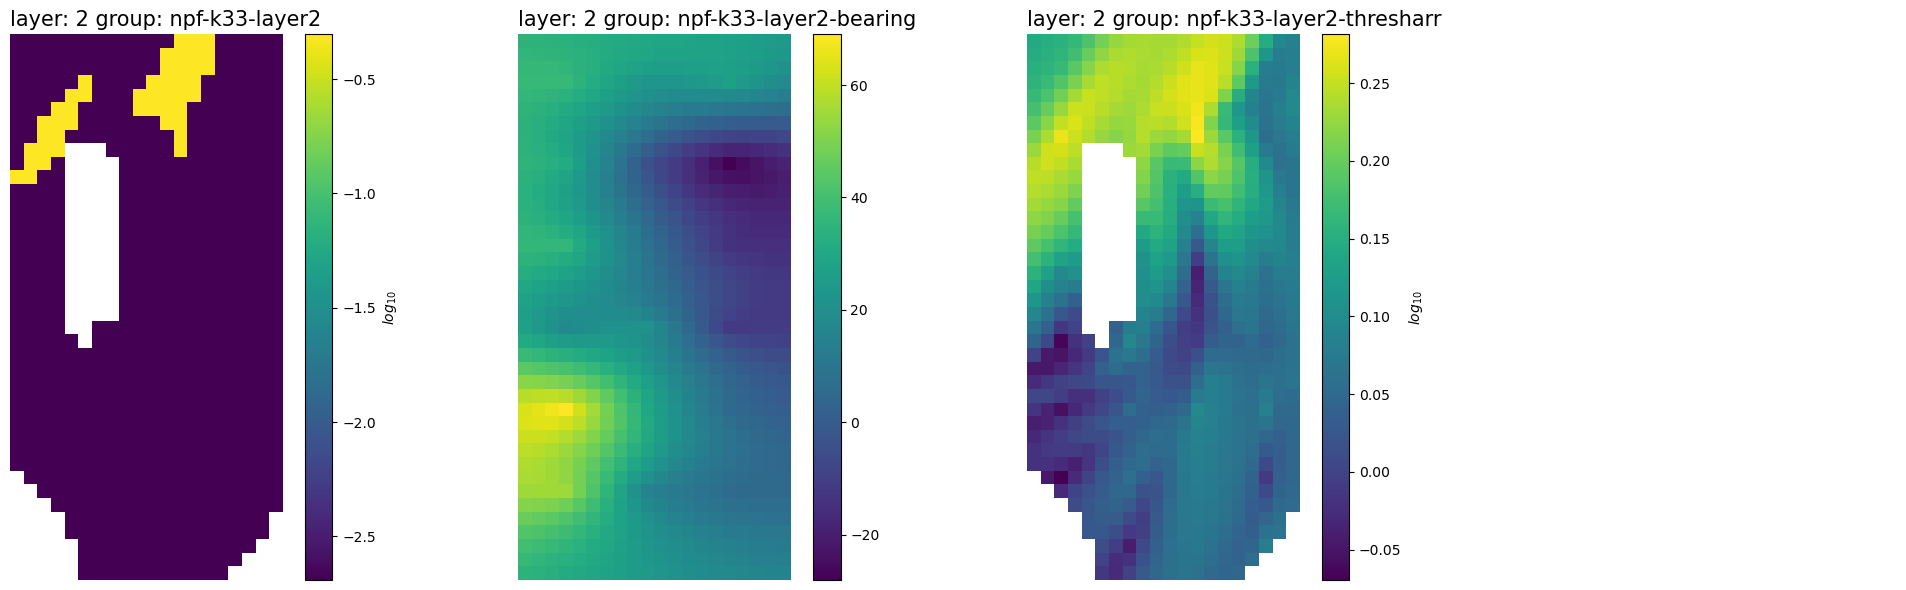

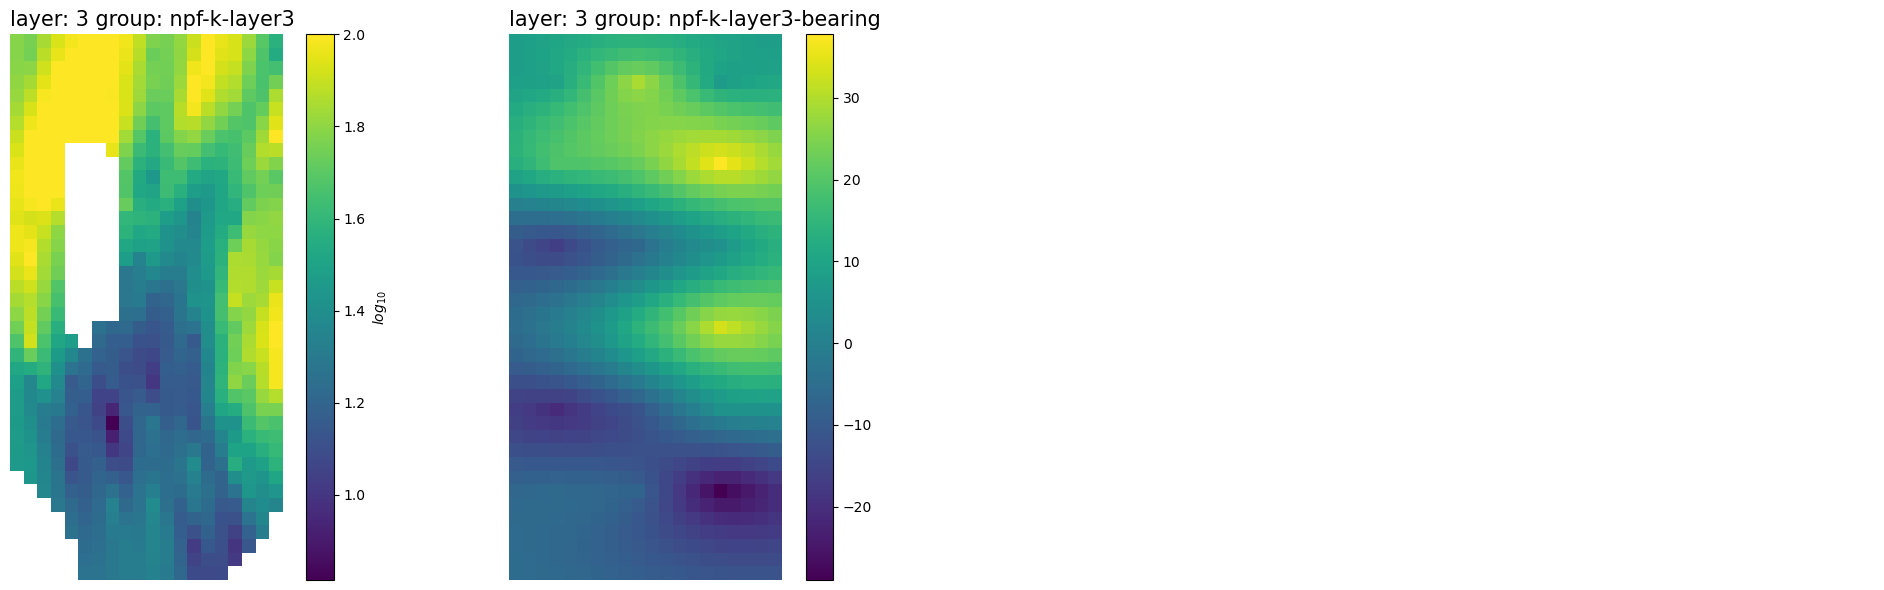

In [37]:
for k in uk:
    kobs = gobs.loc[gobs.k==k,:]
    ug = kobs.obgnme.unique()
    ug.sort()
    fig,axes = plt.subplots(1,4,figsize=(20,6))
    axes = np.atleast_1d(axes)
    for ax in axes:
        ax.set_frame_on(False)
        ax.set_yticks([])
        ax.set_xticks([])
    for g,ax in zip(ug,axes):
        gkobs = kobs.loc[kobs.obgnme==g,:]
        
        arr = np.zeros_like(top_arr)
        arr[gkobs.i,gkobs.j] = res.loc[gkobs.obsnme,"modelled"].values
        ax.set_aspect("equal")
        label = ""
        if "bearing" not in g and "aniso" not in g:
            arr = np.log10(arr)
            label = "$log_{10}$"
        cb = ax.imshow(arr)
        plt.colorbar(cb,ax=ax,label=label)
        ax.set_title("layer: {0} group: {1}".format(k+1,g),loc="left",fontsize=15)
        
    plt.tight_layout()
    plt.show()
    plt.close(fig)

Stunning isn't it?!  There is clearly a lot subjectivity in the form of defining the prior for the hyper parameters required to use these non-stationary geostats, but they do afford more opportunities to express (stochastic) expert knowledge.  To be honest, there was a lot of experimenting with this notebook to get these figures to look this way - playing with variograms and parameter initial values and bounds a lot.  You encouraged to do the same!  scroll back up, change things, and "restart kernel and run all" - this will help build some better intution, promise....